# Setup

In [2]:
import argparse
import models
from aug import aug
from dataset import load

import numpy as np
import torch as th
import torch.nn as nn

from eval import label_classification
import warnings

warnings.filterwarnings('ignore')


def count_parameters(model):
    return sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])


parser = argparse.ArgumentParser()
parser.add_argument('--dataname', type=str, default='cora')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--split', type=str, default='random')
parser.add_argument('--seed', type=int, default=100)

parser.add_argument('--method', type=str, default='regular')
parser.add_argument('--grad_target', type=float, default=0.01)

parser.add_argument('--epochs', type=int, default=200, help='Number of training periods.')
parser.add_argument('--lr', type=float, default=0.001, help='Learning rate.')
parser.add_argument('--wd', type=float, default=1e-5, help='Weight decay.')
parser.add_argument('--temp', type=float, default=1.0, help='Temperature.')

parser.add_argument('--act_fn', type=str, default='relu')

parser.add_argument("--hid_dim", type=int, default=256, help='Hidden layer dim.')
parser.add_argument("--out_dim", type=int, default=256, help='Output layer dim.')

parser.add_argument("--num_layers", type=int, default=2, help='Number of GNN layers.')
parser.add_argument('--der1', type=float, default=0.2, help='Drop edge ratio of the 1st augmentation.')
parser.add_argument('--der2', type=float, default=0.2, help='Drop edge ratio of the 2nd augmentation.')
parser.add_argument('--dfr1', type=float, default=0.2, help='Drop feature ratio of the 1st augmentation.')
parser.add_argument('--dfr2', type=float, default=0.2, help='Drop feature ratio of the 2nd augmentation.')

args = parser.parse_args("")

if args.gpu != -1 and th.cuda.is_available():
    args.device = 'cuda:{}'.format(args.gpu)
else:
    args.device = 'cpu'

np.random.seed(args.seed)
th.manual_seed(args.seed)

if args.device != 'cpu':
    th.cuda.manual_seed(args.seed)


# Step 1: Load hyperparameters =================================================================== #
lr = args.lr
hid_dim = args.hid_dim
out_dim = args.out_dim

num_layers = args.num_layers
act_fn = ({'relu': nn.ReLU(), 'prelu': nn.PReLU()})[args.act_fn]

drop_edge_rate_1 = args.der1
drop_edge_rate_2 = args.der2
drop_feature_rate_1 = args.dfr1
drop_feature_rate_2 = args.dfr2

temp = args.temp
epochs = args.epochs
wd = args.wd

# Data load

In [26]:
# Step 2: Prepare data =================================================================== #
graph = load(args.dataname)
in_dim = graph.ndata['feat'].shape[1]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


# GRACE

In [11]:
import dgl
import importlib
importlib.reload(models)
import numpy as np

def aug_weight(graph: dgl.DGLGraph, drop_feat: float, weight: th.Tensor):
  edge_mask = th.bernoulli(weight) == 0
  masked_edges = graph.adj().coalesce().indices()[:, edge_mask]
  new_graph = dgl.graph((masked_edges[0], masked_edges[1]), num_nodes=graph.num_nodes()).to(graph.device)
  feat_mask = th.rand((graph.ndata['feat'].shape[1])) < (drop_feat)
  new_graph.ndata['feat'] = graph.ndata['feat'].clone()
  new_graph.ndata['feat'][:, feat_mask] = 0
  # new_graph = new_graph.add_self_loop()
  new_graph.edata['edge'] = torch.ones([new_graph.num_edges()]).float().requires_grad_()
  return new_graph, edge_mask

In [50]:
import torch
method = args.method
grad_target = args.grad_target

losses = np.zeros(epochs)
model = models.Grace(in_dim, hid_dim, out_dim, num_layers, act_fn, temp)
optimizer = th.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

graph.edata['weight'] = th.full([graph.num_edges()], 0.2)
graph.edata['edge'] = th.full([graph.num_edges()], 1.0).requires_grad_()

if method == 'regular':
  model = model.to(args.device)
  for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    graph1, mask1 = aug_weight(graph, drop_feature_rate_1, graph.edata['weight'])
    graph2, mask2 = aug_weight(graph, drop_feature_rate_2, graph.edata['weight'])

    graph1 = graph1.to(args.device)
    graph2 = graph2.to(args.device)

    loss = model(
        graph1, 
        graph2, 
        graph1.ndata['feat'],
        graph2.ndata['feat'],
        g1_weights=graph1.edata['edge'],
        g2_weights=graph2.edata['edge'],
        )
    losses[epoch] = loss.item()
    loss.backward()
    optimizer.step()
    
elif method == 'oneview':
  model = model.to(args.device)
  for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    graph1, mask1 = aug_weight(graph, drop_feature_rate_1, graph.edata['weight'])
    graph1 = graph1.to(args.device)

    loss = model(
        graph1, 
        graph.to(args.device), 
        graph1.ndata['feat'], 
        graph.ndata['feat'].to(args.device),
        g1_weights=graph1.edata['edge'],
        g2_weights=graph.edata['edge'].to(args.device))

    losses[epoch] = loss.item()
    loss.backward()
    optimizer.step()

elif method == 'grad_positive':
  model = model.to(args.device)
  for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    graph1, mask1 = aug_weight(graph, drop_feature_rate_1, graph.edata['weight'])
    graph2, mask2 = aug_weight(graph, drop_feature_rate_2, graph.edata['weight'])
    graph1 = graph1.to(args.device)
    graph2 = graph2.to(args.device)

    loss = model(
        graph1, 
        graph2, 
        graph1.ndata['feat'], 
        graph2.ndata['feat'],
        g1_weights=graph1.edata['edge'],
        g2_weights=graph2.edata['edge'],
        )

    losses[epoch] = loss.item()
    graph1.edata['edge'].retain_grad()
    graph2.edata['edge'].retain_grad()
    loss.backward()

    edge_grad = torch.zeros(graph.num_edges())
    edge_grad[mask1] += graph1.edata['edge'].grad.detach().cpu()
    edge_grad[mask2] += graph2.edata['edge'].grad.detach().cpu()

    scaled = edge_grad * (grad_target * graph.num_edges() / (edge_grad.abs().sum() * (epoch + 1)))
    graph.edata['weight'] = (graph.edata['weight'] + scaled).clamp(0, 1)

    optimizer.step()
  
  method = f'{method}_{grad_target}'

elif method == 'grad_negative':
  model = model.to(args.device)
  for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    graph1, mask1 = aug_weight(graph, drop_feature_rate_1, graph.edata['weight'])
    graph2, mask2 = aug_weight(graph, drop_feature_rate_2, graph.edata['weight'])
    graph1 = graph1.to(args.device)
    graph2 = graph2.to(args.device)

    loss = model(
        graph1, 
        graph2, 
        graph1.ndata['feat'], 
        graph2.ndata['feat'],
        g1_weights=graph1.edata['edge'],
        g2_weights=graph2.edata['edge'],
        )

    losses[epoch] = loss.item()
    graph1.edata['edge'].retain_grad()
    graph2.edata['edge'].retain_grad()
    loss.backward()

    edge_grad = torch.zeros(graph.num_edges())
    edge_grad[mask1] += graph1.edata['edge'].grad.detach().cpu()
    edge_grad[mask2] += graph2.edata['edge'].grad.detach().cpu()

    scaled = edge_grad * (grad_target * graph.num_edges() / (edge_grad.abs().sum() * (epoch + 1)))
    graph.edata['weight'] = (graph.edata['weight'] - scaled).clamp(0, 1)

    optimizer.step()
  
  method = f'{method}_{grad_target}'

elif method == 'oneview_grad_positive':
  model = model.to(args.device)
  for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    graph1, mask1 = aug_weight(graph, drop_feature_rate_1, graph.edata['weight'])
    graph1 = graph1.to(args.device)

    loss = model(
        graph1, 
        graph.to(args.device), 
        graph1.ndata['feat'], 
        graph.ndata['feat'].to(args.device),
        g1_weights=graph1.edata['edge'],
        g2_weights=graph.edata['edge'].to(args.device))

    losses[epoch] = loss.item()
    graph.edata['edge'].retain_grad()
    loss.backward()

    edge_grad = graph.edata['edge'].grad.detach().cpu()
    scaled = edge_grad * (grad_target * graph.num_edges() / (edge_grad.abs().sum() * (epoch + 1)))
    graph.edata['weight'] = (graph.edata['weight'] + scaled).clamp(0, 1)

    optimizer.step()
  
  method = f'{method}_{grad_target}'

elif method == 'oneview_grad_negative':
  model = model.to(args.device)
  for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    graph1, mask1 = aug_weight(graph, drop_feature_rate_1, graph.edata['weight'])
    graph1 = graph1.to(args.device)

    loss = model(
        graph1, 
        graph.to(args.device), 
        graph1.ndata['feat'], 
        graph.ndata['feat'].to(args.device),
        g1_weights=graph1.edata['edge'],
        g2_weights=graph.edata['edge'].to(args.device))

    losses[epoch] = loss.item()
    graph.edata['edge'].retain_grad()
    loss.backward()

    edge_grad = graph.edata['edge'].grad.detach().cpu()
    scaled = edge_grad * (grad_target * graph.num_edges() / (edge_grad.abs().sum() * (epoch + 1)))
    graph.edata['weight'] = (graph.edata['weight'] - scaled).clamp(0, 1)

    optimizer.step()
  
  method = f'{method}_{grad_target}'

In [18]:
import sys
import os
sys.path.append(os.path.join('../..'))
import Utils.Export as Export

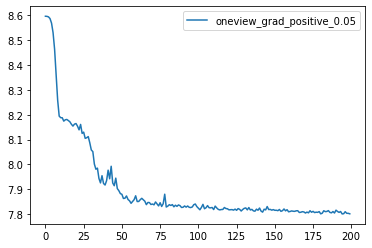

In [51]:
import matplotlib.pyplot as plt
plt.plot(losses, label=method)
plt.legend()

In [52]:
# Step 5: Linear evaluation ============================================================== #
print("=== Final ===")

# graph = graph.add_self_loop()
# graph = graph.to(args.device)
embeds = model.get_embedding(graph.to(args.device), graph.ndata['feat'].to(args.device))

'''Evaluation Embeddings  '''
acc = label_classification(embeds, graph.ndata['label'], graph.ndata['train_mask'], graph.ndata['test_mask'], split=args.split)

=== Final ===
(E) | label_classification: F1Mi=0.7830+-0.0058, F1Ma=0.7568+-0.0031


In [23]:
results = {
    "dataname": args.dataname,
    "seed": args.seed,
    "epochs": args.epochs,
    "method": method,
    "der1": args.der1,
    "der2": args.der2,
    "dfr1": args.dfr1,
    "dfr2": args.dfr2,
    "f1_micro": acc['F1Mi']['mean'],
    "f1_macro": acc['F1Ma']['mean'],
}

for idx, v in enumerate(losses):
    results[f'loss_{idx}'] = v

Export.saveData('./resultsMethods.csv', results)